# Confronto metodi per Kuramoto-Shinomoto-Sakaguchi MV-SDE

Questo codice non fa altro che richiamare le funzioni di entrambi i metodi usati per risolvere l'SDE di Kuramoto-Shinomoto-Sakaguchi. In primis la risolveremo col metodo Eulero - Monte Carlo e poi col metodo di Discesa Stocastica del Gradiente e vediamo di quanto differiscono le due soluzioni.

Scriviamo la MV-SDE relativa al modello di Kuramoto-Shinomoto-Sakaguchi, ovvero:

$$ dX_t = \left( \mathbb{E}[sen(X_t)] cos(X_t) - \mathbb{E}[cos(X_t)] sen(X_t) \right) dt + \sigma dW_t , \ \ \ X_0=x_0. $$

Da questa equazione differenziale si evince che:
* K = 3, d = 1 e q = 1,
* $\varphi(x)=(1, senx, cosx)$, 
* $\alpha(t,x)=(0, cosx, -senx)^T$, 
* $\beta(t,x)=(\sigma, 0 , 0)^T$.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

def average(Y):
    num = Y.size
    X = sum(Y) / num
    return X

## Metodo di Eulero - Monte Carlo 

In [3]:
def eulero1(c1, c2, sigma, h, M, X):
    W = np.random.normal(0, 1, M) 
    drift = c1 * np.cos(X) - c2 * np.sin(X) 
    diffusione = sigma 
    X = X + drift * h + diffusione * math.sqrt(h) * W 
    
    return X

def monte_carlo(c1, c2, a1, a2, sigma, T, N, M, X0):
    h = T / N
    X = X0 * np.ones(M)
    gamma1 = [average(np.sin(X))]
    gamma2 = [average(np.cos(X))]
    
    for i in range(N):
        X = eulero1(c1 + a1 * gamma1[-1], c2 + a2 * gamma2[-1], sigma, h, M, X)
        gamma1.append(average(np.sin(X)))
        gamma2.append(average(np.cos(X)))
    
    return X, np.array(gamma1), np.array(gamma2) 

## Metodo di Discesa del Gradiente

In [4]:
def base(T, N, n, X0, tipo):
    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)
    
    if tipo == 'canonica':
        g = np.array([ cc ** i for i in range(n+1)]) 
        
        a1_0 = np.sin(X0) * g[:,0]
        a2_0 = np.cos(X0) * g[:,0]
        
        return a1_0, a2_0, g
    
    elif tipo == 'lagrange':
        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
        a1_0 = np.sin(X0) * np.ones(n+1) 
        a2_0 = np.cos(X0) * np.ones(n+1) 

        return a1_0, a2_0, g 
        
    
    else:
        return 'err'
    
def step_eulero(c1, c2, sigma, i, h, M, X, Z, YY1, YY2, g):
    W = np.random.normal(0, 1, (2, M)) 
    
    X = X + (c1 * np.cos(X) - c2 * np.sin(X)) * h + sigma * math.sqrt(h) * W[0] 
    
    YY1 = YY1 + ((g[:,i] * np.ones((M, 1))).transpose() * np.cos(Z) - YY1 * (c1 * np.sin(Z) + c2 * np.cos(Z))) * h
    YY2 = YY2 + ((-g[:,i] * np.ones((M, 1))).transpose() * np.sin(Z) - YY2 * (c1 * np.sin(Z) + c2 * np.cos(Z))) * h
    
    Z = Z + (c1 * np.cos(Z) - c2 * np.sin(Z)) * h + sigma * math.sqrt(h) * W[1]
    
    
    return X, Z, YY1, YY2

def eulero(a1, a2, sigma, n, N, M, Z0, h, g):
    
    X = Z0 * np.ones((N+1, M))
    Z = Z0 * np.ones((N+1, M))
    Y1 = np.zeros((N+1, n+1, M))
    Y2 = np.zeros((N+1, n+1, M))
    
    for i in range(N):
        c1 = np.dot(a1, g[:,i])
        c2 = np.dot(a2, g[:,i])
        YY1 = Y1[i]
        YY2 = Y2[i]
        X[i+1], Z[i+1], Y1[i+1], Y2[i+1] = step_eulero(c1, c2, sigma, i, h, M, X[i], Z[i], YY1, YY2, g)
    
    return X, Z, Y1, Y2

def gradiente(Z, Ztilde, Y1tilde, Y2tilde, a1, a2, n, M, h, g):
    v1 = np.zeros(n+1)
    v2 = np.zeros(n+1)
    
    for j in range(n+1): 
        
        q1 = np.sin(Z) - (np.dot(a1,g) * np.ones((M, 1))).transpose()
        q2 = np.cos(Ztilde) * Y1tilde[:,j] - (g[j,:] * np.ones((M, 1))).transpose()
        q3 = np.cos(Z) - (np.dot(a2,g) * np.ones((M, 1))).transpose()
        q4 = -np.sin(Ztilde) * Y1tilde[:,j]
        
        v1[j] = average( 2 * h * sum(q1 * q2 + q3 * q4 ) ) 
        
        q1 = np.sin(Z) - (np.dot(a1,g) * np.ones((M, 1))).transpose()
        q2 = np.cos(Ztilde) * Y2tilde[:,j] 
        q3 = np.cos(Z) - (np.dot(a2,g) * np.ones((M, 1))).transpose() 
        q4 = -np.sin(Ztilde) * Y2tilde[:,j] - (g[j,:] * np.ones((M, 1))).transpose()
        
        v2[j] = average( 2 * h * sum( q1 * q2 + q3 * q4 ) )

    return v1, v2

def discesa_stocastica_del_gradiente(a1_0, a2_0, n, r0, rho, m, sigma, N, M, X0, h, g):
    a1 = a1_0 
    a2 = a2_0
    for mm in range(m):
        eta = r0 / ((mm + 1) ** rho)
        
        Z, Ztilde, Y1tilde, Y2tilde = eulero(a1, a2, sigma, n, N, M, X0, h, g)
        
        v1, v2 = gradiente(Z, Ztilde, Y1tilde, Y2tilde, a1, a2, n, M, h, g) 
        
        a1 = a1 - eta * v1
        a2 = a2 - eta * v2
        
    return a1, a2

## Main

Concludiamo riportando il main che richiama le funzioni sopra definite. Ricordiamo a cosa corrisponderanno i valori che daremo in input alle funzioni che richiameremo:
* N : numero di iterazioni (steps temporali),
* M : numero di simulazioni in ogni istante,
* T : istante finale,
* $\mu$ : funzione di Drift,
* $\sigma$ : funzione di Diffuzione,
* h : step temporale,
* $X_0$ : dato iniziale.

Richiameremo inoltre:
* n: dimensione dello spazio dei polinomi,
* $a_0$: valore iniziale del vettore del metodo SGD. Ora è semplificata, poi ci mettiamo lo sviluppo di Taylor di Kolmogorov di gamma1+gamma2,
* $r_0$ e $\rho$: servono per i learning rates e devono essere  $r_0 \in (0, +\infty)$ e $\frac{1}{2} < \rho \leq 1$ ,
* m: num di step per il mtodo SGD,
* M: mini batch tra SGD e GD

In [13]:
if __name__ == "__main__":
    
    # Parametri in Input Comuni
    
    sigma = 0.5
    T = 1
    N = 100
    X0 = 0.5
    
    # Parametri in Input Eulero-Monte Carlo
    
    c1 = 0
    c2 = 0
    aa1 = 1
    aa2 = 1
    M = 100000
    
    # Parametri in Input Discesa Del Gradiente
    
    h = T / N
    n = 5   
    r0 = 10
    rho = 0.9
    m = 50000
    M1 = 1 
    tipo = 'lagrange'
    
    a1_0, a2_0, g = base(T, N, n, X0, tipo)
    
    start = time.process_time()   # parte il cronometro
    X, gamma1, gamma2 = monte_carlo(c1, c2, aa1, aa2, sigma, T, N, M, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione Eulero - Monte Carlo: ", end - start)
    
    start = time.process_time()   # parte il cronometro
    a1, a2 = discesa_stocastica_del_gradiente(a1_0, a2_0, n, r0, rho, m, sigma, N, M1, X0, h, g)
    end = time.process_time()   # si ferma il cronometro

    print("Tempo di esecuzione Discesa del Gradiente: ", end - start)

Tempo di esecuzione Eulero - Monte Carlo:  2.25
Tempo di esecuzione Discesa del Gradiente:  330.046875


Grafico dell'approssimazione di $\mathbb{E}[sen(X)]$.

In [1]:
fig = plt.figure() 
plt.title("Confronto MC [" + str(M) + " simulazioni] e SGD [" + str(m) + " passi]") 
plt.xlabel("Step temporali") 
plt.ylabel("Evoluzione di E[sen(X)]") 
# plt.ylim(0.4, 0.9) # se non c'è il grafico è molto zoomato
plt.plot(np.dot(a1, g), label='(La)1(t)')
plt.plot(gamma1, label='gamma1')
plt.legend()
plt.show() 

NameError: name 'plt' is not defined

Grafico dell'approssimazione di $\mathbb{E}[cos(X)]$.

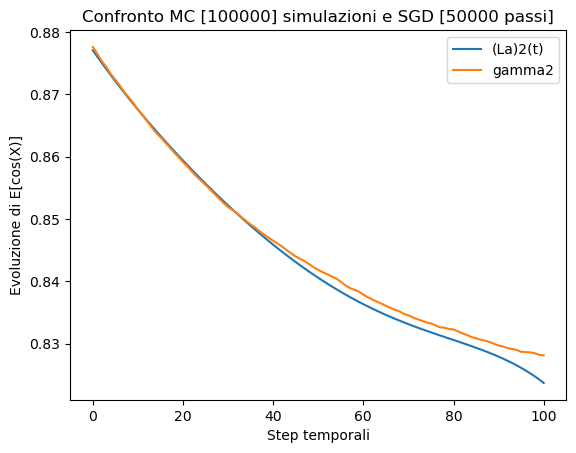

In [15]:
fig = plt.figure() 
plt.title("Confronto MC [" + str(M) + " simulazioni] e SGD [" + str(m) + " passi]") 
plt.xlabel("Step temporali") 
plt.ylabel("Evoluzione di E[cos(X)]") 
# plt.ylim(0.4, 0.9) # se non c'è il grafico è molto zoomato
plt.plot(np.dot(a2, g), label='(La)2(t)')
plt.plot(gamma2, label='gamma2')
plt.legend()
plt.show() 